# Frozen Lake - How to test different policies

❄️ [FrozenLake](https://gym.openai.com/envs/FrozenLake-v0/)


Winter is here. You and your friends were tossing around a frisbee at the park when you made a wild throw that left the frisbee out in the middle of the lake. The water is mostly frozen, but there are a few holes where the ice has melted. If you step into one of those holes, you'll fall into the freezing water. At this time, there's an international frisbee shortage, so it's absolutely imperative that you navigate across the lake and retrieve the disc. However, the ice is slippery, so you won't always move in the direction you intend.

The surface is described using a grid like the following:

````
SFFF       (S: starting point, safe)
FHFH       (F: frozen surface, safe)
FFFH       (H: hole, fall to your doom)
HFFG       (G: goal, where the frisbee is located)
````

The episode ends when you reach the goal or fall in a hole. You receive a reward of 1 if you reach the goal, and zero otherwise.

In [1]:
import gym.envs.toy_text.frozen_lake as fl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import perf_counter
np.set_printoptions(precision=3)
SEED = int("WasFurEineUnverstandlichePraktischeSitzung", base=36) 

In [ ]:
# Create environment
env = fl.FrozenLakeEnv()  # gym.make('FrozenLake-v1')
env.seed(SEED)

env.render() #Renders the lake


SFFF
FHFH
FFFH
HFFG


### 0. Helpers

In [ ]:
def to_s(row, col):
    return row * env.ncol + col

def to_row_col(s):
    col = s % env.ncol
    row = s // env.ncol
    return row, col

def print_values(v):
    for row in range(env.nrow):
        for col in range(env.ncol):
            s = f"{v[to_s(row, col)]:.3}"
            print(s, end=' ' * (8 - len(s)))
        print("")


def convert_time(t1, t2):
    """
    t1 (datetime): end_time
    t2 (datetime): start_time

    return:
    ------
    diff (str): difference between t2 and t1
    """
    return f"Running time: {t2 - t1:.4f} sec\n"

def plot_heatmap(V_simple_pi):
    """
    Plot the heatmap for value function
    """
    fig, ax = plt.subplots(figsize=(4, 6))
    plt.title('Value function for each starting point on the grid')
    sns.set(rc={'figure.facecolor':'white'})
    sns.heatmap(V_simple_pi.reshape(4,4),cmap="YlGn",annot=True, fmt=".3f",linewidth=0.3,cbar_kws={"shrink": .8})

### 1. Installation
Everything is installed and works fine by running the ``check_env.py`` file. 

### 2. Discovering the environment 
When running the ``discover.py`` file, we understand more the situation. 

States are $s \in \llbracket 0, 15\rrbracket$ (4 rows of 4 tiles)

Actions are drawn in:
- LEFT (0)
- DOWN (1)
- RIGHT (2)
- UP (3)

Rewards are suchs that they are zero for all states expect the last one (state 15) where the reward is equal to 1. 

The Markov Decision Process is such that when you chose to move according to a certain direction $x \in \llbracket 0, 3 \rrbracket$ then there is a $\frac{1}{3}$ probability that you will go in this direction, a $\frac{1}{3}$ probability that you will go in the $x-1 \mod 4$ direction and a $\frac{1}{3}$ probability that you will go in the $x+1 \mod 4$ direction. If you try to move against the boundary of the lake, you'll just don't move.



### 3. Monte-Carlo estimation of the value function
In each state $s$, simulate $n$ trajectories, $((s_t^i)_{t≥0})_{1≤i≤n}$ following policy $\pi$ and compute

$$\hat{V}^\pi ≃ \frac{1}{n}\sum\sum\gamma^tr(s_t^i,\pi(s_t^i))$$

When running the ``hint_question3.py`` file, we get the following graph :

Value estimate of the starting point: 0.0136


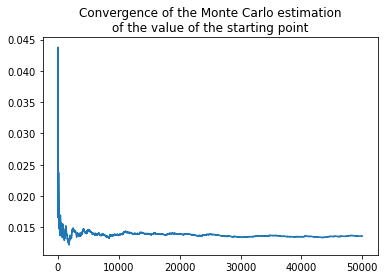

In [ ]:
NBR_EPISODES = 50000
HORIZON = 200
GAMMA = 0.9

# First interaction with the environment
VALUE_START = np.zeros(NBR_EPISODES)

for i_episode in range(NBR_EPISODES):
    env.reset()
    done = False
    t = 0
    discount = 1
    while (not done) and (t < HORIZON):
        next_state, reward, done, _ = env.step(fl.RIGHT)
        VALUE_START[i_episode] += discount * reward
        discount *= GAMMA
        t += 1

print(f"Value estimate of the starting point: {np.mean(VALUE_START):.4f}")

offset = 10
plt.figure()
plt.title("Convergence of the Monte Carlo estimation\nof the value of the \
starting point")
plt.plot((np.cumsum(VALUE_START) / (np.arange(NBR_EPISODES) + 1))[offset:])
plt.show()



We can see that the value converges around 0.0130 which is the value of the starting point for strategy "RIGHT only".

In [ ]:
print(f'This policy succeeds in: {sum(VALUE_START !=0)/len(VALUE_START)*100:.2f}% of the cases')

This policy succeeds in: 3.25% of the cases


### 4. Expected value method. 

We define a function that takes a policy $\pi$ and outputs its value function $V^\pi$ using Monte-Carlo estimation to compute it.

$$\hat{V}^\pi ≃ \frac{1}{n}\sum\sum\gamma^tr(s_t^i,\pi(s_t^i))$$



######################
##### Question 4 #####
######################

EXPECTED VALUE METHOD

Running time: 31.6467 sec

Value estimate of the starting point: 0.013
Value function of the always RIGHT policy:



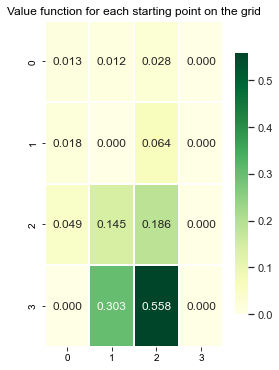

In [ ]:
NBR_EPISODES = 50000
HORIZON = 200
GAMMA = 0.9

# Question 4
print("\n\n######################")
print("##### Question 4 #####")
print("######################\n")
print("EXPECTED VALUE METHOD\n")


def value_function_expected(pi):
    """
    pi : int array
    For each index i, pi[i] is the action (int) chosen in state i
    (ie) a number of state long np array that defines the policy
    for each states of the environment
    return a value vector that gives the value function for each state
    of the environment using Monte Carlo estimation

    return:
    ------
    V_pi : float array
    For each index i, V_pi[i] is the value (float) of the state i
    """
    v_pi = np.zeros(env.nS)
    for s in range(env.nS):
        v_s = 0
        s_c = s
        env.isd = np.zeros(env.nS)
        env.isd[s] = 1
        env.reset()
        for _ in range(NBR_EPISODES):
            env.reset()
            done = False
            t = 0
            discount = 1
            while not done and t < HORIZON:
                t += 1
                s_c, r, done, _ = env.step(pi[s_c])
                v_s += discount * r
                discount *= GAMMA
        v_pi[s] = v_s / NBR_EPISODES
    return v_pi


simple_pi = fl.RIGHT * np.ones(env.nS)
starting_time = perf_counter()
V_simple_pi = value_function_expected(simple_pi)

print(convert_time(starting_time, perf_counter()))
print(f"Value estimate of the starting point: {V_simple_pi[0]:.3f}")
print(f"Value function of the always RIGHT policy:\n")
#print_values(V_simple_pi)
plot_heatmap(V_simple_pi)

# reset the original isd
env.isd = np.zeros(env.nS)
env.isd[0] = 1

### 5. Linear System Method

We define another function that takes a policy $\pi$ and outputs its value function $V^\pi$ using the linear system method.

$$V^{\pi}(x) = m_{\pi} + \gamma \displaystyle\sum_{y}p_{\pi}(y|x)V^{\pi}(y)$$

So when we write this equation with the probability transition matrix and isolate the $V^{\pi}$ term, we get

$$V^{\pi} = m_{\pi}(I-\gamma P)^{-1}$$

where $I$ is the identity vector and $P$ the probability transition matrix.


######################
##### Question 5 #####
######################

LINEAR SYSTEM METHOD

Running time: 0.0003 sec

Value estimate of the starting point: 0.013
Value function of the always RIGHT policy:



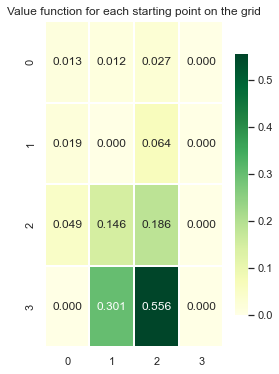

In [ ]:
# Question 5
print("\n######################")
print("##### Question 5 #####")
print("######################\n")
print("LINEAR SYSTEM METHOD\n")


def value_function(pi):
    """
    pi : int array
    For each index i, pi[i] is the action (int) chosen in state i

    return:
    ------
    V_pi : float array
    For each index i, V_pi[i] is the value (float) of the state i
    """
    # Compute both the reward vector r_pi and
    # transition matrix P_pi associated to the policy on the given env
    r_pi = np.zeros(env.nS)
    transition_pi = np.zeros((env.nS, env.nS))
    for state in range(env.nS):
        transitions_info = env.P[state][pi[state]]
        for transition in transitions_info:
            probabilities, next_state, reward, _ = transition
            transition_pi[state, next_state] += probabilities
            r_pi[state] += reward * probabilities
    # Compute the value function of the policy pi
    identity = np.eye(env.nS)
    return np.linalg.inv(identity - GAMMA * transition_pi) @ r_pi


simple_pi = fl.RIGHT * np.ones(env.nS)
starting_time = perf_counter()
V_simple_pi = value_function(simple_pi)
print(convert_time(starting_time, perf_counter()))
print(f"Value estimate of the starting point: {V_simple_pi[0]:.3f}")
print(f"Value function of the always RIGHT policy:\n")
#print_values(V_simple_pi)
plot_heatmap(V_simple_pi)

It seems that the values obtained by both algorithms are really close to each other. However, the linear system calculation worked **way faster** that the Monte Carlo estimation.

### 6. Bellman Operator Method
The Bellman step is defined as follows :

$$ \mathcal{T}_\pi[v] = m_\pi + \gamma P_\pi v$$ 

The contraction property of the Bellman operator ensures that: 

$$ V_\pi =  \mathcal{T}_\pi[V_\pi] $$


######################
##### Question 6 #####
######################

BELLMAN OPERATOR METHOD

Running time: 0.0164 sec

Value function of the always RIGHT policy:


Number of iterations: 45
Last residual 0.000000


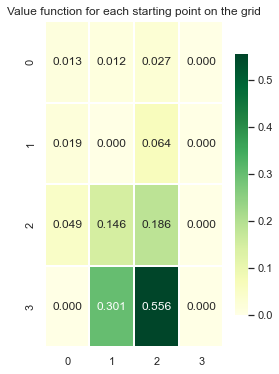

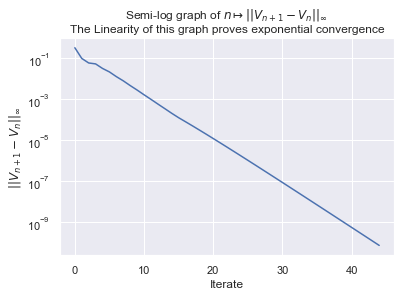

In [ ]:
# Question 6
print("\n######################")
print("##### Question 6 #####")
print("######################\n")
print("BELLMAN OPERATOR METHOD\n")


def value_function_2(pi, epsilon, max_iter):
    """
    pi : int array
    For each index i, pi[i] is the action (int) chosen in state i

    epsilon : float
    Used as a threshold for the stopping rule

    max_iter : int
    Hard threshold on the number of loops

    return:
    ------
    V_pi : float array
    For each index i, V_pi[i] is the value (float) of the state i
    """
    # Compute both the reward vector r_pi and
    # transition matrix P_pi associated to the policy on the given env
    r_pi = np.zeros(env.nS)
    transition_pi = np.zeros((env.nS, env.nS))
    for state in range(env.nS):
        transitions_info = env.P[state][pi[state]]
        for transition in transitions_info:
            probability, next_state, reward, _ = transition
            transition_pi[state, next_state] += probability
            r_pi[state] += reward * probability
    # Compute the value function V_pi of the policy pi
    v_pi = np.zeros(env.nS)
    v_pi_old = np.zeros(env.nS)
    delta_inf = np.zeros(max_iter)
    stop = False
    i = 0
    while (not stop) and (i < max_iter):
        v_pi = r_pi + GAMMA * (transition_pi @ v_pi_old)
        delta_inf[i] = np.max(np.abs(v_pi - v_pi_old))
        v_pi_old[:] = v_pi
        if delta_inf[i] < epsilon:
            stop = True
            delta_inf = delta_inf[:i + 1]
        i += 1
    return v_pi, delta_inf


starting_time = perf_counter()
V_simple_pi, Delta_inf = value_function_2(simple_pi, 1e-10, 10000)
print(convert_time(starting_time, perf_counter()))
print(f"Value function of the always RIGHT policy:\n")
#print_values(V_simple_pi)
plot_heatmap(V_simple_pi)

plt.figure()
plt.title("Semi-log graph of $n \mapsto || V_{n+1} - V_n ||_\infty $ \n\
The Linearity of this graph proves exponential convergence")
plt.semilogy(Delta_inf)
plt.xlabel("Iterate")
plt.ylabel(r'$|| V_{n+1} - V_n ||_\infty$')
plt.savefig('question6.png')
print(f"\nNumber of iterations: {Delta_inf.size}")
print(f"Last residual {Delta_inf[-1]:.6f}")


The stopping criterions, used in this Bellman Operator methods is a threshold that was compared to the norm of the difference between a value function and its iteration. I

We can notice that the convergence is fast, for a threshold of 1e-10, only 45 iterations were needed. 


### 7. Optimal Bellman Operator

The Bellman optimal operator is defined as follows :

$$ \mathcal{T}[v] = \max_{a} m_a + \gamma P_av$$ 

The contraction property of the Bellman operator ensures that: 

$$ V =  \mathcal{T}[V] $$


######################
##### Question 7 #####
######################

OPTIMAL BELLMAN OPERATOR

Running time: 0.0076 sec

Optimal value function:


Number of iterations: 49
Last residual 0.000000


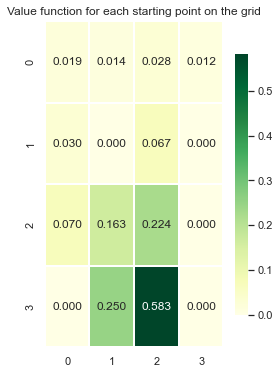

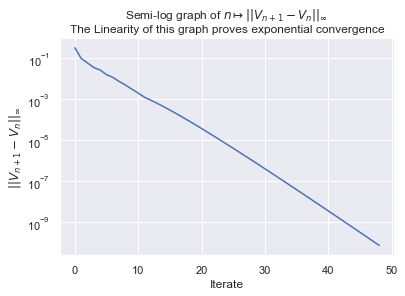

In [ ]:
# Question 7
print("\n######################")
print("##### Question 7 #####")
print("######################\n")
print("OPTIMAL BELLMAN OPERATOR\n")
from itertools import combinations_with_replacement

#def possible_policies(env):
#    actions = np.arange(env.action_space.n)
#    return np.array(list(combinations_with_replacement(actions, 16)))

def bellman_optimal(m_action, v_opt, transition_action):
    v_action = []
    for action in range(env.nA):
        v_action += [list(m_action[action] + GAMMA * (transition_action[action] @ v_opt))]
    return v_action[np.argmax(np.array(v_action).sum(axis=1))]

def value_function_optimal(epsilon, max_iter):
    """
    epsilon : float
    Used as a threshold for the stopping rule

    max_iter : int
    Hard threshold on the number of loops

    returns:
    -------
    V_opt : float array, (env.nS,) size
    Optimal value function on the FrozenLake MDP given a discount GAMMA
    V_opt[state index] = Value of that state
    """
    # Compute both the reward vector m_action and
    # transition matrix P_action associated to the action on the given env
    m_action = np.zeros((env.nA, env.nS))
    transition_action = np.zeros((env.nA, env.nS, env.nS))
    
    for action in range(env.nA):
        for state in range(env.nS):
            transitions_info = env.P[state][action]
            for transition in transitions_info:
                probability, next_state, reward, _ = transition
                transition_action[action, state, next_state] += probability
                m_action[action, state] += reward * probability

    # Compute the value function V_pi of the policy pi
    v_opt = np.zeros(env.nS)
    v_opt_old = np.zeros(env.nS)
    delta_inf = np.zeros(max_iter)
    stop = False
    i = 0
    while (not stop) and (i < max_iter):
        v_opt = bellman_optimal(m_action,v_opt,transition_action)
        delta_inf[i] = np.max(np.abs(v_opt - v_opt_old))
        v_opt_old[:] = v_opt
        if delta_inf[i] < epsilon:
            stop = True
            delta_inf = delta_inf[:i + 1]
        i += 1
    return np.array(v_opt), delta_inf

starting_time = perf_counter()
V_opt, Delta_inf = value_function_optimal(1e-10, 10000)
print(convert_time(starting_time, perf_counter()))
print(f"Optimal value function:\n")
#print_values(V_opt)
plot_heatmap(V_opt)

plt.figure()
plt.title("Semi-log graph of $n \mapsto || V_{n+1} - V_n ||_\infty $ \n\
The Linearity of this graph proves exponential convergence")
plt.semilogy(Delta_inf)
plt.xlabel("Iterate")
plt.ylabel(r"$|| V_{n+1} - V_n ||_\infty$")
plt.savefig('question7.png')
print(f"\nNumber of iterations: {Delta_inf.size}")
print(f"Last residual {Delta_inf[-1]:.6f}")


Here we used the Optimal Bellman Operator to implement a function that uteratively applies the operator to computer the optimal value function $V^{*}$. We can see that the value for the first state is quite different from the one we saw earlier with the strategy of only moving right.

### 8. Value Iteration Algorithm
The Bellman greedy operator is defined as follows :

$$\mathcal{G}[v] = \argmax_{a} m_a + \gamma P_av$$


In [ ]:
# Question 8
print("\n######################")
print("##### Question 8 #####")
print("######################\n")
print("VALUE ITERATION\n")

def bellman_greedy(v_opt,m_action,transition_action):
    pi_opt = np.zeros(env.nS)
    for state in range(env.nS):
        best_action = 0
        best_value = 0
        for action in range(env.nA):
            temp = m_action[action, state] + GAMMA * (transition_action[action] @ v_opt)[state]
            if temp > best_value:
                best_value = temp
                best_action = action
        pi_opt[state] = best_action
    return pi_opt

def value_iteration(epsilon, max_iter):
    """
    epsilon : float
    Used as a threshold for the stopping rule

    max_iter : int
    Hard threshold on the number of loops

    returns:
    -------
    pi : int array, size (env.nS,)
    An optimal policy
    """
    # Compute both the reward vector r_pi and
    # transition matrix P_pi associated to the policy on the given env
    m_action = np.zeros((env.nA, env.nS))
    transition_action = np.zeros((env.nA, env.nS, env.nS))
    
    for action in range(env.nA):
        for state in range(env.nS):
            transitions_info = env.P[state][action]
            for transition in transitions_info:
                probability, next_state, reward, _ = transition
                transition_action[action, state, next_state] += probability
                m_action[action, state] += reward * probability

    v_opt,_ = value_function_optimal(epsilon, max_iter)
    pi_opt = bellman_greedy(v_opt,m_action,transition_action)
    return pi_opt


ARROWS = {
    fl.RIGHT: "→",
    fl.LEFT: "←",
    fl.UP: "↑",
    fl.DOWN: "↓"
}

def print_policy(pi):
    for row in range(env.nrow):
        for col in range(env.ncol):
            print(ARROWS[pi[to_s(row, col)]], end='')
        print("")

starting_time = perf_counter()
Pi_opt = value_iteration(1e-4, 1000)
print(convert_time(starting_time, perf_counter()))
print("An optimal policy is:\n")
print_policy(Pi_opt)


######################
##### Question 8 #####
######################

VALUE ITERATION

Running time: 0.0024 sec

An optimal policy is:

←↑←↑
←←←←
↑↓←←
←→↓←


Thanks to the value iteration algorithm, we managed to find the optima policy to walk on the frozen lake. We used the same function as for the calculation of the optimal value function and added the calculation of the policy in the process.

### 9. Policy Iteration Algorithm

We start with some policy $\pi_0$ initialized arbitrarily.

We compute $v_{n+1} = \mathcal{T}_{\pi_n}^{\infty} = (I-\gamma P_{\pi_n})^{-1}m_{\pi_n}$.

We calculate $\pi_{n+1} = \mathcal{G}[v_n]$.

Stop if $v_{n+1} = v_{n}$.

In [ ]:
# Question 9
print("\n######################")
print("##### Question 9 #####")
print("######################\n")
print("POLICY ITERATION\n")


# The danger of Policy Iteration lies in the stopping criterion
# If not careful, one might end up with an algorithm that does not
# terminate and oscillates between optimal policies
# Even if it is computationally more expensive, we sometimes rather
# compare value functions of the policies than policies from one iterate
# to another.

# An easy improvement on the following code would be to use
# a warm start for policy evaluation steps (if iteration methods is used)
# That is to say, using the previously computed value function
# as the first step for the next policy evaluation

def policy_iteration(max_iter):
    """
    epsilon : float
    Used as a threshold for the stopping rule

    max_iter : int
    Hard threshold on the number of loops

    returns:
    -------
    pi : int array, size (env.nS,)
    An optimal policy
    """
    pi = np.random.randint(0,env.nA,size = env.nS)
    value = value_function(pi)
    
    m_action = np.zeros((env.nA, env.nS))
    transition_action = np.zeros((env.nA, env.nS, env.nS))
    
    for action in range(env.nA):
        for state in range(env.nS):
            transitions_info = env.P[state][action]
            for transition in transitions_info:
                probability, next_state, reward, _ = transition
                transition_action[action, state, next_state] += probability
                m_action[action, state] += reward * probability

    next_pi =  bellman_greedy(value,m_action,transition_action)
    next_value = value_function(next_pi)

    i = 0
    while not np.array_equal(next_value, value) and i < max_iter:
        pi = next_pi
        value = next_value
        next_pi = bellman_greedy(value,m_action,transition_action)
        next_value = value_function(next_pi)
        i += 1

    print(f"Stopped after {i} iterations")  
    return pi


starting_time = perf_counter()
Pi_opt = policy_iteration(1000)
print(convert_time(starting_time, perf_counter()))
print("An optimal policy is:\n")
print_policy(Pi_opt)


######################
##### Question 9 #####
######################

POLICY ITERATION

Stopped after 3 iterations
Running time: 0.0035 sec

An optimal policy is:

←↑←↑
←←←←
↑↓←←
←→↓←


### 10. Comments

As we can see, the results given by both algorithms are the same. 

We can also notice that the number of iterations needed for the policy iteration algorithm is less than the number of iterations needed of the value iteration algorithm. 

This is because the policy iteration directly uses the exact formula to calculate the value function whereas the value iteration calculates it with an approximation method.

### 11. Q-learning Algorithm

The optimal Bellman operator for Q-learning is :

$$\mathcal{T}[q] = (s,a) \rightarrow m(s,a) + \gamma \displaystyle\sum_{s'}P_a(s'|s)\max_{a}q(s',a)$$


#######################
##### Question 11 #####
#######################

OPTIMAL Q-BELLMAN OPERATOR METHOD

Running time: 0.1103 sec


Number of iterations: 53
Last residual 0.000099


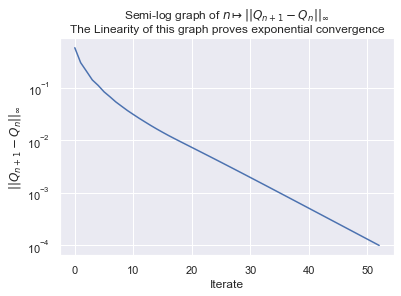

In [ ]:
# Question 11
print("\n#######################")
print("##### Question 11 #####")
print("#######################\n")
print("OPTIMAL Q-BELLMAN OPERATOR METHOD\n")

def q_bellman_operator(q,m_action,transition_action):
    next_q = np.zeros((env.nS,env.nA))
    for state in range(env.nS):
        for action in range(env.nA):
            quality = m_action[action,state]
            for state2 in range(env.nS):
                max_q = 0
                for action2 in range(env.nA):
                    temp = q[state2,action2]
                    if temp > max_q:
                        max_q = temp
                quality += GAMMA * transition_action[action,state,state2] * max_q
            next_q[state,action] = quality
    return next_q

def state_value_function_optimal(epsilon, max_iter):
    """
    epsilon : float
    Used as a threshold for the stopping rule

    max_iter : int
    Hard threshold on the number of loops

    returns:
    -------
    q_opt : float array, (env.nS, env.nA) size
    Optimal state-action value function on the FrozenLake MDP
    given a discount GAMMA
    q_opt[state index][action index] = state-action value of that state
    """
    m_action = np.zeros((env.nA, env.nS))
    transition_action = np.zeros((env.nA, env.nS, env.nS))
    
    for action in range(env.nA):
        for state in range(env.nS):
            transitions_info = env.P[state][action]
            for transition in transitions_info:
                probability, next_state, reward, _ = transition
                transition_action[action, state, next_state] += probability
                m_action[action, state] += reward * probability
    
    q_opt =  np.zeros((env.nS,env.nA))
    q_opt_old =  np.zeros((env.nS,env.nA))
    delta_inf = np.zeros(max_iter)
    stop = False
    i = 0
    while (not stop) and (i < max_iter):
        q_opt = q_bellman_operator(q_opt,m_action,transition_action)
        delta_inf[i] = np.linalg.norm(q_opt-q_opt_old)
        q_opt_old[:] = q_opt
        if delta_inf[i] < epsilon:
            stop = True
            delta_inf = delta_inf[:i + 1]
        i += 1
    return q_opt, delta_inf


starting_time = perf_counter()
Q_opt, Delta_inf = state_value_function_optimal(1e-4, 100)
print(convert_time(starting_time, perf_counter()))
# print(Q_opt)
#V_opt = None
#print(f"Optimal value function:\n")
#print(Q_opt)

plt.figure()
plt.title("Semi-log graph of $n \mapsto || Q_{n+1} - Q_n ||_\infty $ \n\
The Linearity of this graph proves exponential convergence")
plt.semilogy(Delta_inf)
plt.xlabel("Iterate")
plt.ylabel(r"$|| Q_{n+1} - Q_n ||_\infty$")
plt.savefig('question11.png')
print(f"\nNumber of iterations: {Delta_inf.size}")
print(f"Last residual {Delta_inf[-1]:.6f}")

We managed to calculate the optimal q vector with threshold 1e-10 in 154 iterations. 

Now we can deduce the policy by applying a greedy formula.

### 12. Getting Policy from Quality

$$\pi_{\star} = \mathcal{G}[q] = \argmax_{a}q(s,a)$$

In [ ]:
# Question 12
print("\n#######################")
print("##### Question 12 #####")
print("#######################\n")

Pi_opt = np.argmax(Q_opt, axis=1)
print("\nAn optimal policy is:\n")
print_policy(Pi_opt)


#######################
##### Question 12 #####
#######################


An optimal policy is:

←↑←↑
←←←←
↑↓←←
←→↓←


We can see that we get the same result than Value Iteration and Policy Iteration.

### 13. Comparaison
Now, let's test if our policy (which is the same for the 3 algorithms) is a good policy to get our friend through the frozen lake !

In [ ]:
# Question 13
print("\n#######################")
print("##### Question 13 #####")
print("#######################\n")
print("RENDER A TRAJECTORY")


# render policy
def trajectory(pi, max_moves=100):
    done = False
    i = 0
    env.reset()
    cumulative_reward = 0
    discount = 1
    while not done and i < max_moves:
        i += 1
        _, r, done, _ = env.step(pi[env.s])
        cumulative_reward += discount*r
        discount *= GAMMA
    if done and env.s != env.nS-1:
        print("You've fallen in a hole !")
    elif done:
        print("The GOAL has been reached! Congrats! :-)")
    env.render()
    return cumulative_reward,i

cr,i = trajectory(Pi_opt)
print(f"The cumulative discounted reward along the above trajectory is: {cr:.5f} and reached the frisbee with {i} iterations")



#######################
##### Question 13 #####
#######################

RENDER A TRAJECTORY
The GOAL has been reached! Congrats! :-)
  (Down)
SFFF
FHFH
FFFH
HFFG
The cumulative discounted reward along the above trajectory is: 0.06461 and reached the frisbee with 27 iterations
